In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/projects/

/content/drive/MyDrive/projects


In [3]:
# !git clone https://github.com/ukairia777/tensorflow-nlp-tutorial.git

In [3]:
cd /content/drive/MyDrive/projects/fra-eng-translation-with-t5-from-scratch

/content/drive/MyDrive/projects/fra-eng-translation-with-t5-from-scratch


# **1. DATA ENGINEERING**

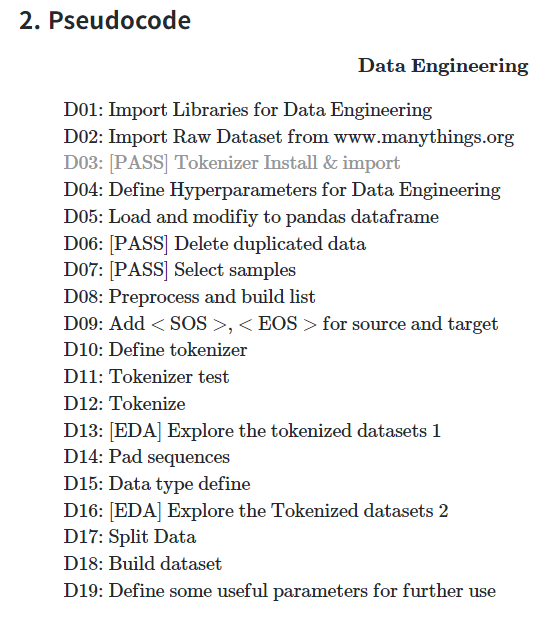

# 1. Import Libraries for Data Engineering

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
import tensorflow as tf
import re

In [6]:
SEED = 1234
tf.random.set_seed(SEED)

In [8]:
AUTO = tf.data.experimental.AUTOTUNE # to enable automatic tuning of parameters for better performanc


# 2. Import IMDB Raw Dataset from Auther's gdrive

In [ ]:
# cmd = "wget http://www.manythings.org/anki/fra-eng.zip"
# os.system(cmd)
# cmd = ('unzip fra-eng.zip')
# os.system(cmd)

In [ ]:
# ! wget http://www.manythings.org/anki/fra-eng.zip
# ! unzip fra-eng.zip

In [ ]:
"""
# Raw Data Download Option

import urllib3
import zipfile
import shutil

http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)
"""

# 3. Tokenizer Install & import

Keras Tokenizer is a tokenizer provided by default in tensorflow 2.X and is a word level tokenizer. It does not require a separate installation

# 4. Define Hyperparameters for Data Engineering

In [9]:
ENCODER_LEN  = 41
DECODER_LEN  = ENCODER_LEN
BATCH_SIZE   = 128
BUFFER_SIZE  = 20000 #???
num_examples = 1024*12  ## why 1024*12 ???

# 5. Load and modifiy to pandas dataframe

In [10]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

In [11]:
train_df = pd.read_csv('fra.txt', names=['SRC', 'TRG', 'lic'], sep='\t')

In [12]:
train_df.tail()


,SRC,TRG,lic
229798,"Death is something that we're often discouraged to talk about or even think about, but I've realized that preparing for death is one of the most empowering things you can do. Thinking about death clarifies your life.",La mort est une chose qu'on nous décourage souvent de discuter ou même de penser mais j'ai pris conscience que se préparer à la mort est l'une des choses que nous puissions faire qui nous investit le plus de responsabilité. Réfléchir à la mort clarifie notre vie.,CC-BY 2.0 (France) Attribution: tatoeba.org #1969892 (davearms) & #1969962 (sacredceltic)
229799,"Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.","Puisqu'il y a de multiples sites web sur chaque sujet, je clique d'habitude sur le bouton retour arrière lorsque j'atterris sur n'importe quelle page qui contient des publicités surgissantes. Je me rends juste sur la prochaine page proposée par Google et espère tomber sur quelque chose de moins irritant.",CC-BY 2.0 (France) Attribution: tatoeba.org #954270 (CK) & #957693 (sacredceltic)
229800,"If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.","Si quelqu'un qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif, cela veut dire qu'il a probablement remarqué quelque chose à propos de votre élocution qui lui a fait prendre conscience que vous n'êtes pas un locuteur natif. En d'autres termes, vous ne parlez pas vraiment comme un locuteur natif.",CC-BY 2.0 (France) Attribution: tatoeba.org #953936 (CK) & #955961 (sacredceltic)
229801,"It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.","Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs.",CC-BY 2.0 (France) Attribution: tatoeba.org #2024159 (CK) & #2024564 (sacredceltic)
229802,"I went drinking with one of my boyfriend's friends, and now he's furious at me. ""Was this friend a guy or a girl?"" ""A guy, obviously. Why would I go drinking with his female friends?"" ""Yeah, you're right."" ""His name is Tom. He's really hot, and I really want to go drinking with him again.""","« Je suis allée boire avec un ami de mon compagnon, et voilà qu'il est furieux contre moi. » « Était-ce un gars ou une fille ? » « Un gars, bien évidemment. Pourquoi irais-je boire avec ses amies ? » « Ouais, ça se comprend. » « Il s'appelle Tom. Il est trop canon, et j'ai tellement envie d'aller prendre un verre avec lui à nouveau. »",CC-BY 2.0 (France) Attribution: tatoeba.org #9821215 (DJ_Saidez) & #11726136 (Micsmithel)


In [13]:
del train_df['lic']

In [14]:
print(len(train_df))

train_df = train_df.loc[:, 'SRC':'TRG']

train_df.head()

229803


,SRC,TRG
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


In [15]:
train_df["src_len"] = ""
train_df["trg_len"] = ""
train_df.head()

,SRC,TRG,src_len,trg_len
0,Go.,Va !,,
1,Go.,Marche.,,
2,Go.,En route !,,
3,Go.,Bouge !,,
4,Hi.,Salut !,,


In [16]:
# [OPT] Count the number of words
for idx in range(len(train_df['SRC'])):
    # initialize string
    text_eng = str(train_df.iloc[idx]['SRC'])

    # default separator: space
    result_eng = len(text_eng.split())
    train_df.at[idx, 'src_len'] = int(result_eng)

    text_fra = str(train_df.iloc[idx]['TRG'])
    # default separator: space
    result_fra = len(text_fra.split())
    train_df.at[idx, 'trg_len'] = int(result_fra)

print('Translation Pair :',len(train_df)) # Print Dataset Siz

Translation Pair : 229803


In [17]:
train_df

,SRC,TRG,src_len,trg_len
0,Go.,Va !,1,2
1,Go.,Marche.,1,1
2,Go.,En route !,1,3
3,Go.,Bouge !,1,2
4,Hi.,Salut !,1,2
...,...,...,...,...
229798,"Death is something that we're often discouraged to talk about or even think about, but I've realized that preparing for death is one of the most empowering things you can do. Thinking about death clarifies your life.",La mort est une chose qu'on nous décourage souvent de discuter ou même de penser mais j'ai pris conscience que se préparer à la mort est l'une des choses que nous puissions faire qui nous investit le plus de responsabilité. Réfléchir à la mort clarifie notre vie.,37,47
229799,"Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.","Puisqu'il y a de multiples sites web sur chaque sujet, je clique d'habitude sur le bouton retour arrière lorsque j'atterris sur n'importe quelle page qui contient des publicités surgissantes. Je me rends juste sur la prochaine page proposée par Google et espère tomber sur quelque chose de moins irritant.",43,49
229800,"If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.","Si quelqu'un qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif, cela veut dire qu'il a probablement remarqué quelque chose à propos de votre élocution qui lui a fait prendre conscience que vous n'êtes pas un locuteur natif. En d'autres termes, vous ne parlez pas vraiment comme un locuteur natif.",44,55
229801,"It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.","Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs.",47,51


# 6. Delete duplicated data

In [18]:

train_df = train_df.drop_duplicates(subset = ["SRC"])
print('Translation Pair :',len(train_df)) # Print Dataset Size

train_df = train_df.drop_duplicates(subset = ["TRG"])
print('Translation Pair :',len(train_df)) # Print Dataset Size

Translation Pair : 164178
Translation Pair : 147009


In [19]:
train_df

,SRC,TRG,src_len,trg_len
0,Go.,Va !,1,2
4,Hi.,Salut !,1,2
6,Run!,Cours !,1,2
22,Who?,Qui ?,1,2
23,Wow!,Ça alors !,1,3
...,...,...,...,...
229798,"Death is something that we're often discouraged to talk about or even think about, but I've realized that preparing for death is one of the most empowering things you can do. Thinking about death clarifies your life.",La mort est une chose qu'on nous décourage souvent de discuter ou même de penser mais j'ai pris conscience que se préparer à la mort est l'une des choses que nous puissions faire qui nous investit le plus de responsabilité. Réfléchir à la mort clarifie notre vie.,37,47
229799,"Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.","Puisqu'il y a de multiples sites web sur chaque sujet, je clique d'habitude sur le bouton retour arrière lorsque j'atterris sur n'importe quelle page qui contient des publicités surgissantes. Je me rends juste sur la prochaine page proposée par Google et espère tomber sur quelque chose de moins irritant.",43,49
229800,"If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.","Si quelqu'un qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif, cela veut dire qu'il a probablement remarqué quelque chose à propos de votre élocution qui lui a fait prendre conscience que vous n'êtes pas un locuteur natif. En d'autres termes, vous ne parlez pas vraiment comme un locuteur natif.",44,55
229801,"It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.","Il est peut-être impossible d'obtenir un Corpus complètement dénué de fautes, étant donnée la nature de ce type d'entreprise collaborative. Cependant, si nous encourageons les membres à produire des phrases dans leurs propres langues plutôt que d'expérimenter dans les langues qu'ils apprennent, nous pourrions être en mesure de réduire les erreurs.",47,51


# 7. Select samples

In [20]:
num_examples

12288

In [21]:
# Assign the result to a new variable.
is_within_len = (8 < train_df['src_len']) & (train_df['src_len'] < 20) & (8 < train_df['trg_len']) & (train_df['trg_len'] < 20)
# Filter the data that meets the condition and store it in a new variable.
train_df = train_df[is_within_len]

dataset_df_8096 = train_df.sample(n=num_examples, # number of items from axis to return.
          random_state=1234) # seed for random number generator for reproducibility

print('Translation Pair :',len(dataset_df_8096))   # Print Dataset Size

Translation Pair : 12288


# 8. Preprocess and build list

text preprocessing is not transferable from one NLP task to another, and most methods of preprocessing are domain-specific.

In [22]:
import unicodedata

In [23]:
# Source Data
raw_src = []
for sentence in dataset_df_8096['SRC']:
    sentence = sentence.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    raw_src.append(sentence)


In [24]:
# Target Data
raw_trg = []

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')

for sentence in dataset_df_8096['TRG']:
    # 위에서 구현한 함수를 내부적으로 호출
    sentence = unicode_to_ascii(sentence.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sentence = re.sub(r"[^a-zA-Z!.?]+", r" ", sentence)

    sentence = re.sub(r"\s+", " ", sentence)

    raw_trg.append(sentence)

print(raw_src[:5])
print(raw_trg[:5])

['it was in the s that a big earthquake destroyed tokyo .', 'could you hand me the newspaper on the table ?', 'i have to make the best of that small room .', 'an uncle is the brother of one of your parents .', 'he lost almost all the stamps he had collected .']
['c est dans les annees qu un tremblement de terre detruisit tokyo .', 'pourriez vous me passer le journal qui se trouve sur la table ?', 'je dois tirer le meilleur parti de cette petite piece .', 'un oncle est le frere de l un de tes parents .', 'il a perdu presque tous les timbres de sa collection .']


# 9. Add `<SOS>`, `<EOS>` for source and target

In [25]:
SRC_df = pd.DataFrame(raw_src)
TRG_df = pd.DataFrame(raw_trg)

In [26]:
SRC_df

,0
0,it was in the s that a big earthquake destroyed tokyo .
1,could you hand me the newspaper on the table ?
2,i have to make the best of that small room .
3,an uncle is the brother of one of your parents .
4,he lost almost all the stamps he had collected .
...,...
12283,steel production is estimated to reach million tons this year .
12284,"if you let the engine run , you might be able to hear what the problem is ."
12285,"though he would not admit it , he was very tired ."
12286,there were many empty beer cans on the floor .


In [27]:
SRC_df.rename(columns={0: "SRC"}, errors="raise", inplace=True)
TRG_df.rename(columns={0: "TRG"}, errors="raise", inplace=True)
train_df = pd.concat([SRC_df, TRG_df], axis=1)

In [28]:
print('Translation Pair :',len(train_df)) # 리뷰 개수 출력
train_df.sample(10)

Translation Pair : 12288


,SRC,TRG
9964,we had a very nice christmas with tom and his family .,nous avons passe un tres beau noel avec tom et sa famille .
3050,i went to sleep as soon as i got home .,j allai au lit aussitot que je rentrai chez moi .
807,"if you want to become thin , you should cut back on the between meal snacks .",si tu veux maigrir tu devrais arreter de grignoter entre les repas .
9269,my brother is rich enough to buy a car .,mon frere a assez d argent pour s acheter une voiture .
5625,"i am tired , and i make a lot of mistakes when i am tired .",je suis fatigue et je fais beaucoup de fautes quand je suis fatigue .
2331,i have never seen so many good looking men in one place .,je n ai jamais vu tant d hommes gracieux en un meme endroit .
11399,japanese is often said to be a difficult language to learn .,on dit souvent que le japonais est une langue difficile a apprendre .
4505,it will only take a moment to answer the question .,cela prendra seulement un instant pour repondre a la question .
11094,he was not at all satisfied with the result .,il ne fut pas du tout satisfait du resultat .
9667,i ran as fast as possible to catch up with him .,j ai couru le plus vite possible pour le rattraper .


In [29]:
raw_src_df = train_df['SRC']
raw_trg_df = train_df['TRG']

src_sentence = raw_src_df.apply(lambda x: "<SOS> " + str(x) + " <EOS")
trg_sentence = raw_trg_df.apply(lambda x: "<SOS> " + x + " <EOS")

In [30]:
src_sentence[:5],trg_sentence[:5]

(0    <SOS> it was in the s that a big earthquake destroyed tokyo . <EOS
 1             <SOS> could you hand me the newspaper on the table ? <EOS
 2               <SOS> i have to make the best of that small room . <EOS
 3           <SOS> an uncle is the brother of one of your parents . <EOS
 4           <SOS> he lost almost all the stamps he had collected . <EOS
 Name: SRC, dtype: object,
 0    <SOS> c est dans les annees qu un tremblement de terre detruisit tokyo . <EOS
 1       <SOS> pourriez vous me passer le journal qui se trouve sur la table ? <EOS
 2               <SOS> je dois tirer le meilleur parti de cette petite piece . <EOS
 3                        <SOS> un oncle est le frere de l un de tes parents . <EOS
 4                <SOS> il a perdu presque tous les timbres de sa collection . <EOS
 Name: TRG, dtype: object)

# 10. Define tokenizer

`keras.preprocessing.text.Tokenizer` is a very useful tokenizer for text processing in deep learning.

`Tokenizer` assumes that the word tokens of the input texts have been delimited by whitespaces.

`Tokenizer` provides the following functions:

- It will first create a dictionary for the entire corpus (a mapping of each word token and its unique integer index index) (Tokenizer.fit_on_text())
- It can then use the corpus dictionary to convert words in each corpus text into integer sequences (Tokenizer.texts_to_sequences())
- The dictionary is in Tokenizer.word_index  

Notes on `Tokenizer`:

- By default, the token index 0 is reserved for padding token.
- If oov_token is specified, it is default to index 1. (Default: oov_token=False)
- Specify num_words=N for Tokenizer to include only top N words in converting texts to sequences.
- Tokenizer will automatically remove punctuations.
- Tokenizer use the whitespace as word-token delimiter.
- If every character is treated as a token, specify char_level=True.
- Please read Tokenizer documentation very carefully. Very important!!

In [31]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

SRC_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
TRG_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)

SRC_tokenizer.fit_on_texts(src_sentence)
TRG_tokenizer.fit_on_texts(trg_sentence)

src_to_index = SRC_tokenizer.word_index
index_to_src = SRC_tokenizer.index_word

tar_to_index = TRG_tokenizer.word_index
index_to_tar = TRG_tokenizer.index_word

n_enc_vocab = len(SRC_tokenizer.word_index) + 1
n_dec_vocab = len(TRG_tokenizer.word_index) + 1

print('Word set size of Encoder :',n_enc_vocab)
print('Word set size of Decoder :',n_dec_vocab)

Word set size of Encoder : 7150
Word set size of Decoder : 9533


In [32]:
list(SRC_tokenizer.word_index.keys())[:10]

['<unk>', '<sos>', '<eos', 'the', 'to', 'i', 'you', 'a', 'not', 'is']

# 11. Tokenizer test

In [33]:
# Source Tokenizer
lines = [
  "It is winter and the weather is very cold.",
  "Will this Christmas be a white Christmas?",
  "Be careful not to catch a cold in winter and have a happy new year."
]
for line in lines:
    txt_2_ids = SRC_tokenizer.texts_to_sequences([line])
    ids_2_txt = SRC_tokenizer.sequences_to_texts(txt_2_ids)
    print("Input     :", line)
    print("txt_2_ids :", txt_2_ids)
    print("ids_2_txt :", ids_2_txt[0],"\n")

Input     : It is winter and the weather is very cold.
txt_2_ids : [[15, 10, 716, 23, 4, 346, 10, 91, 258]]
ids_2_txt : it is winter and the weather is very cold 

Input     : Will this Christmas be a white Christmas?
txt_2_ids : [[29, 24, 130, 28, 8, 587, 130]]
ids_2_txt : will this christmas be a white christmas 

Input     : Be careful not to catch a cold in winter and have a happy new year.
txt_2_ids : [[28, 525, 9, 5, 409, 8, 258, 13, 716, 23, 17, 8, 378, 119, 179]]
ids_2_txt : be careful not to catch a cold in winter and have a happy new year 



In [34]:
# Target Tokenizer
lines = [
  "C'est l'hiver et il fait très froid.",
  "Ce Noël sera-t-il un Noël blanc ?",
  "Attention à ne pas attraper froid en hiver et bonne année."
]
for line in lines:
    txt_2_ids = TRG_tokenizer.texts_to_sequences([line])
    ids_2_txt = TRG_tokenizer.sequences_to_texts(txt_2_ids)
    print("Input     :", line)
    print("txt_2_ids :", txt_2_ids)
    print("ids_2_txt :", ids_2_txt[0],"\n")

Input     : C'est l'hiver et il fait très froid.
txt_2_ids : [[1, 1, 31, 11, 56, 1, 389]]
ids_2_txt : <unk> <unk> et il fait <unk> froid 

Input     : Ce Noël sera-t-il un Noël blanc ?
txt_2_ids : [[17, 1, 229, 68, 11, 14, 1, 886]]
ids_2_txt : ce <unk> sera t il un <unk> blanc 

Input     : Attention à ne pas attraper froid en hiver et bonne année.
txt_2_ids : [[552, 1, 13, 9, 751, 389, 24, 779, 31, 179, 1]]
ids_2_txt : attention <unk> ne pas attraper froid en hiver et bonne <unk> 



# 12. Tokenize

In [35]:
# tokenize / encode integers / add start and end tokens / padding
tokenized_inputs      = SRC_tokenizer.texts_to_sequences(src_sentence)
tokenized_outputs     = TRG_tokenizer.texts_to_sequences(trg_sentence)



In [37]:
len(tokenized_inputs[2]), tokenized_inputs[2]

(12, [2, 6, 17, 5, 102, 4, 194, 11, 14, 295, 154, 3])

# 13. [EDA] Explore the tokenized datasets 1

It is necessary to take a look at some necessary features. You just need to check whether the total number of data is correct or whether tokenization is successful, and move on. This process is difficult to generalize. Each developer has different information requirements, so please explore the features to suit your taste.

Maximum length of source : 23
Average length of source : 13.135498046875


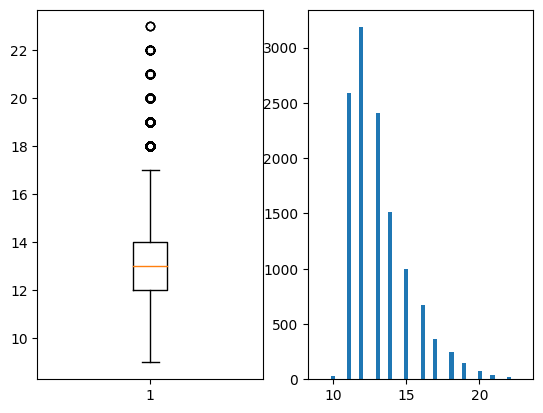

Maximum length of target : 26
Average length of target : 14.287027994791666


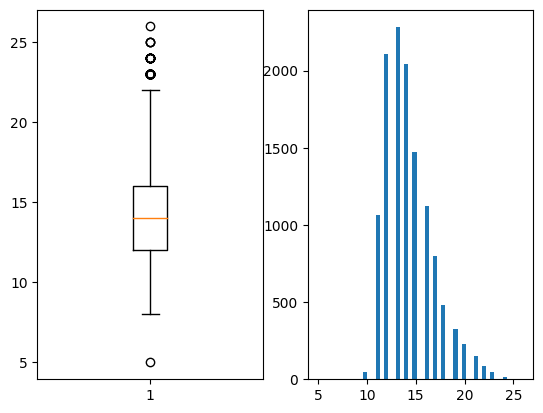

In [38]:
len_result = [len(s) for s in tokenized_inputs]

print('Maximum length of source : {}'.format(np.max(len_result)))
print('Average length of source : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()


len_result = [len(s) for s in tokenized_outputs]

print('Maximum length of target : {}'.format(np.max(len_result)))
print('Average length of target : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

# 14. Pad sequences

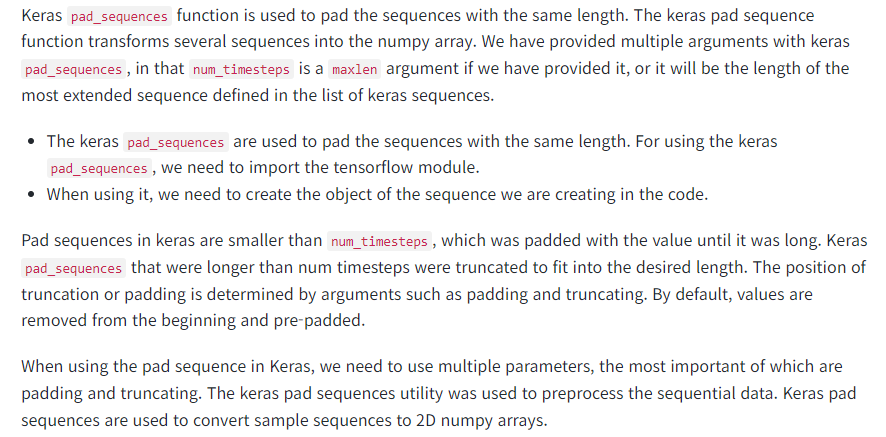

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
tkn_sources = pad_sequences(tokenized_inputs,  maxlen=ENCODER_LEN, padding='post', truncating='post')
tkn_targets = pad_sequences(tokenized_outputs, maxlen=DECODER_LEN, padding='post', truncating='post')

In [40]:
tkn_sources.shape, tkn_sources[:5]

((12288, 41),
 array([[   2,   15,   19,   13,    4,   63,   14,    8,  300,  998, 2178,
          528,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   2,   57,    7,  370,   22,    4,  800,   25,    4,  348,    3,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   2,    6,   17,    5,  102,    4,  194,   11,   14,  295,  154,
            3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   2,   68,  553,   10,    4,  332,   11,   58,   11,   40,  248,
            3,    0,    0,    0,    0,    0,    0,    0,    0,

In [42]:
tkn_targets.shape, tkn_sources[:5]

((12288, 41),
 array([[   2,   15,   19,   13,    4,   63,   14,    8,  300,  998, 2178,
          528,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   2,   57,    7,  370,   22,    4,  800,   25,    4,  348,    3,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   2,    6,   17,    5,  102,    4,  194,   11,   14,  295,  154,
            3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   2,   68,  553,   10,    4,  332,   11,   58,   11,   40,  248,
            3,    0,    0,    0,    0,    0,    0,    0,    0,

# 15. Data type define

When processing raw data, you must pay attention to the data type in the NLP Project. In this implementation, the Data Type is `int64`.

In [43]:
tkn_sources = tf.cast(tkn_sources, dtype=tf.int64)
tkn_targets = tf.cast(tkn_targets, dtype=tf.int64)

In [44]:
tkn_sources[:5]

<tf.Tensor: shape=(5, 41), dtype=int64, numpy=
array([[   2,   15,   19,   13,    4,   63,   14,    8,  300,  998, 2178,
         528,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   57,    7,  370,   22,    4,  800,   25,    4,  348,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    6,   17,    5,  102,    4,  194,   11,   14,  295,  154,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   68,  553,   10,    4,  332,   11,   58,   11,   40,  248,
           3,    0,    0,    0,    0,    0

# 16. [EDA] Explore the Tokenized datasets

In [45]:
print('Size of source language data(shape) :', tkn_sources.shape)
print('Size of target language data(shape) :', tkn_targets.shape)

# Randomly output the 0th sample
print(tkn_sources[0])
print(tkn_targets[0])

Size of source language data(shape) : (12288, 41)
Size of target language data(shape) : (12288, 41)
tf.Tensor(
[   2   15   19   13    4   63   14    8  300  998 2178  528    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0], shape=(41,), dtype=int64)
tf.Tensor(
[   2   46   12   30   26  330   28   14 1405    4  492 4826  578    3
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0], shape=(41,), dtype=int64)


# 17. [PASS] Split Data

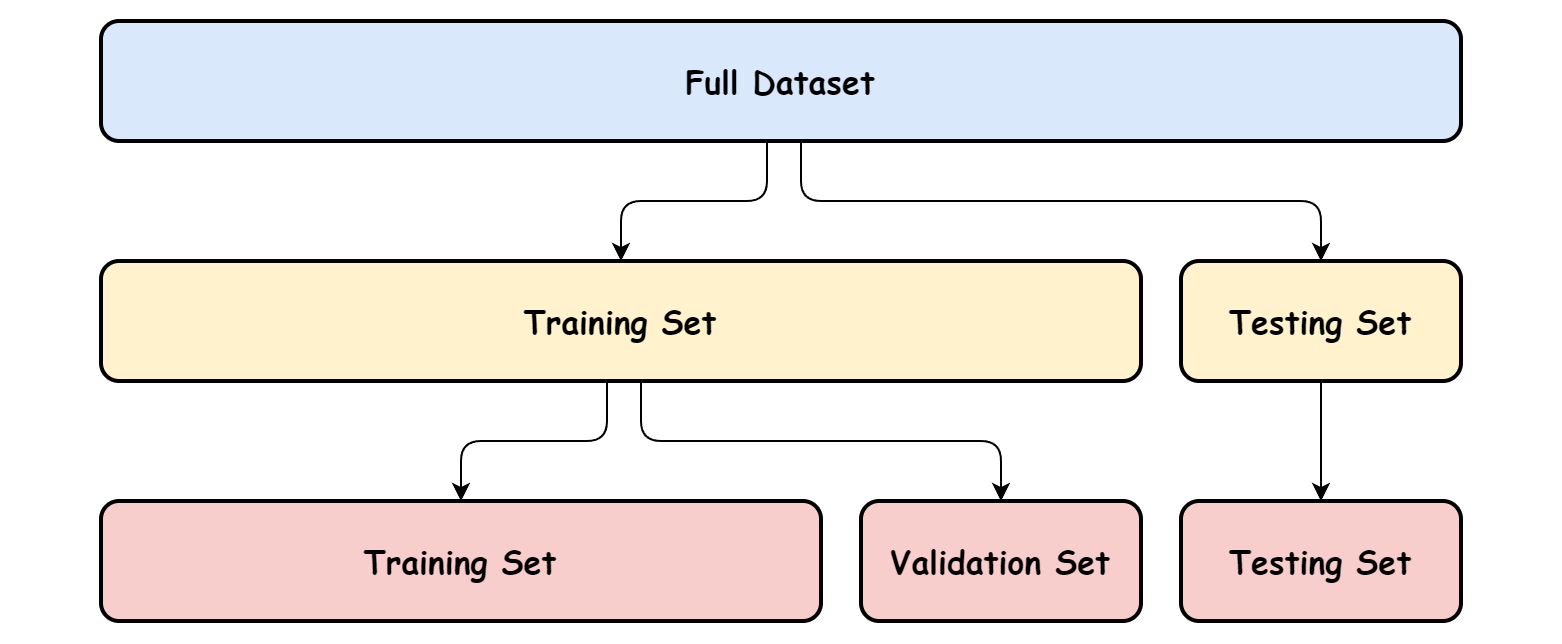

# 18. [PASS] Build dataset

In [46]:
dataset = tf.data.Dataset.from_tensor_slices((tkn_sources, tkn_targets))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print("Inpute Vocabulary Size: {}".format(len(SRC_tokenizer.word_index)))
print("Target Vocabulary Size: {}".format(len(TRG_tokenizer.word_index)))

Inpute Vocabulary Size: 7149
Target Vocabulary Size: 9532


# 19. [PASS] Define some useful parameters for further use

In [47]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

max_length_input  = example_input_batch.shape[1]
max_length_output = example_target_batch.shape[1]

# **3. BUILD T5 MODEL**

# C01. Sinusoid position encoding: NOT USED

# C02. Relative Position Scaled dot product attention

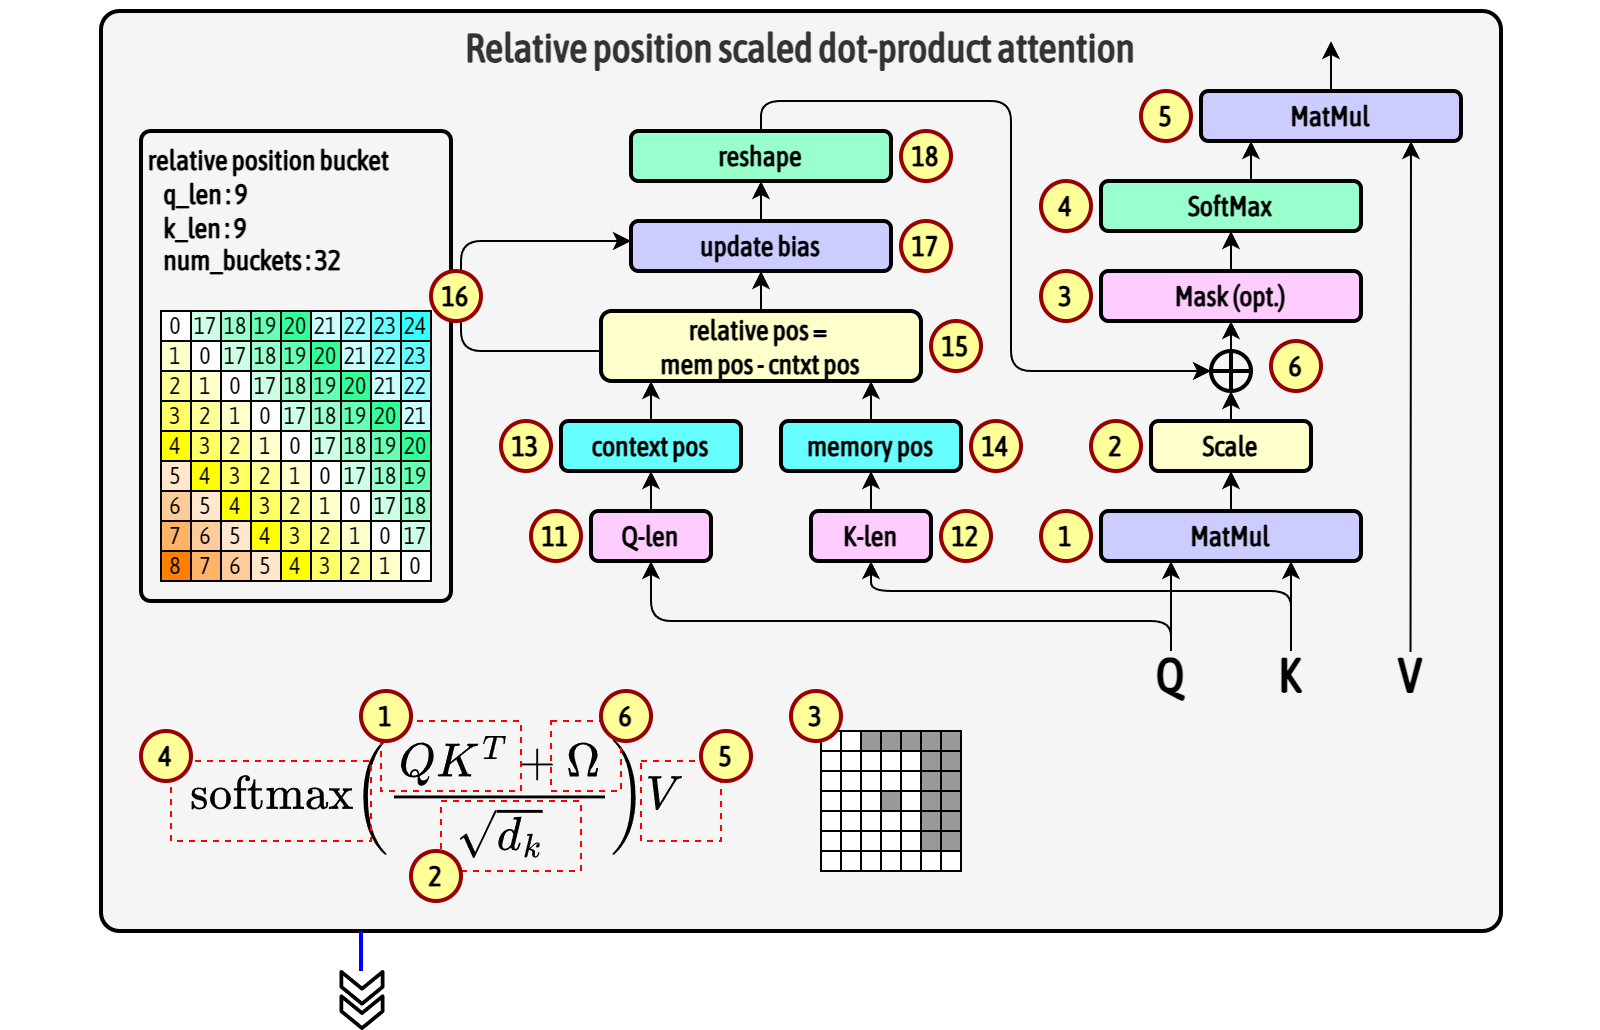

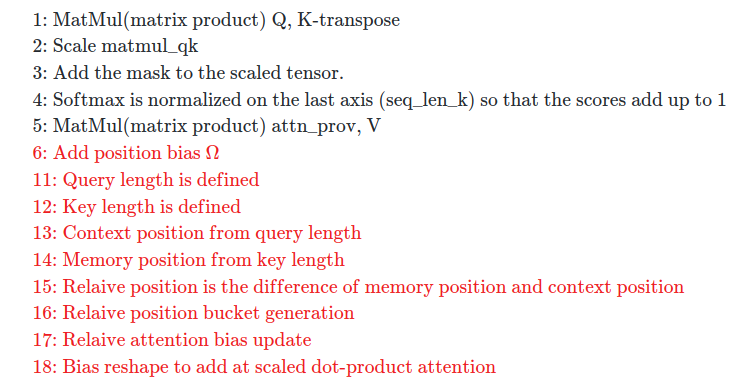

In [ ]:
dropout = 0.3
n_heads = 8

In [ ]:
# C02. Relative Position Scaled dot product attention

class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.num_buckets = 32
        self.relative_attention_bias = tf.keras.layers.Embedding(
            self.num_buckets, n_heads, name="relative_attention_bías"
        )


    def call(self, query, key, value, mask, bidirectional=True):
        # 11. Query length is defined


        # 12. Key length is defined

        # 1. MatMul Q, K-transpose. Attention score matrix.

        # 2. scale matmul_qk

        # 6. Add position bias

        # 3. add the mask to the scaled tensor

        # 4. softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1

        # 5. MatMul attn_prov, V


        return output, attention_weights


    # Compute binned relative position bias
    def compute_bias (self, qlen, klen, bidirectional=True):

        # 13. Context position from query length

        # 14. Memory position from key length

        # 15. Relative position is the difference of memory position and context position

        # 16. Relative position bucket generation


        return values

    def _relative_position_bucket(self, relative_position, num_buckets=32, bidirectional=True, max_distance=128):
        """
        Adapted from Mesh Tensorflow:
        https://github.com/tensorflow/mesh/blob/0cb87fe07da627bf0b7e60475d59f95ed6b5be3d/mesh_tensorflow/transformer/transformer_layers.py#L593

        Translate relative position to a bucket number for relative attention. The relative position is defined as
        memory_position - query_position, i.e. the distance in tokens from the attending position to the attended-to
        position. If bidirectional=False, then positive relative positions are invalid. We use smaller buckets for
        small absolute relative_position and larger buckets for larger absolute relative_positions. All relative
        positions >=max_distance map to the same bucket. All relative positions <=-max_distance map to the same bucket.
        This should allow for more graceful generalization to longer sequences than the model has been trained on

        Args:
            relative_position: an int32 Tensor
            bidirectional: a boolean - whether the attention is bidirectional
            num_buckets: an integer
            max_distance: an integer

        Returns:
            a Tensor with the same shape as relative_position, containing int32 values in the range [0, num_buckets)
        """
        pass

        return relative_buckets

# C03. Multi head attention

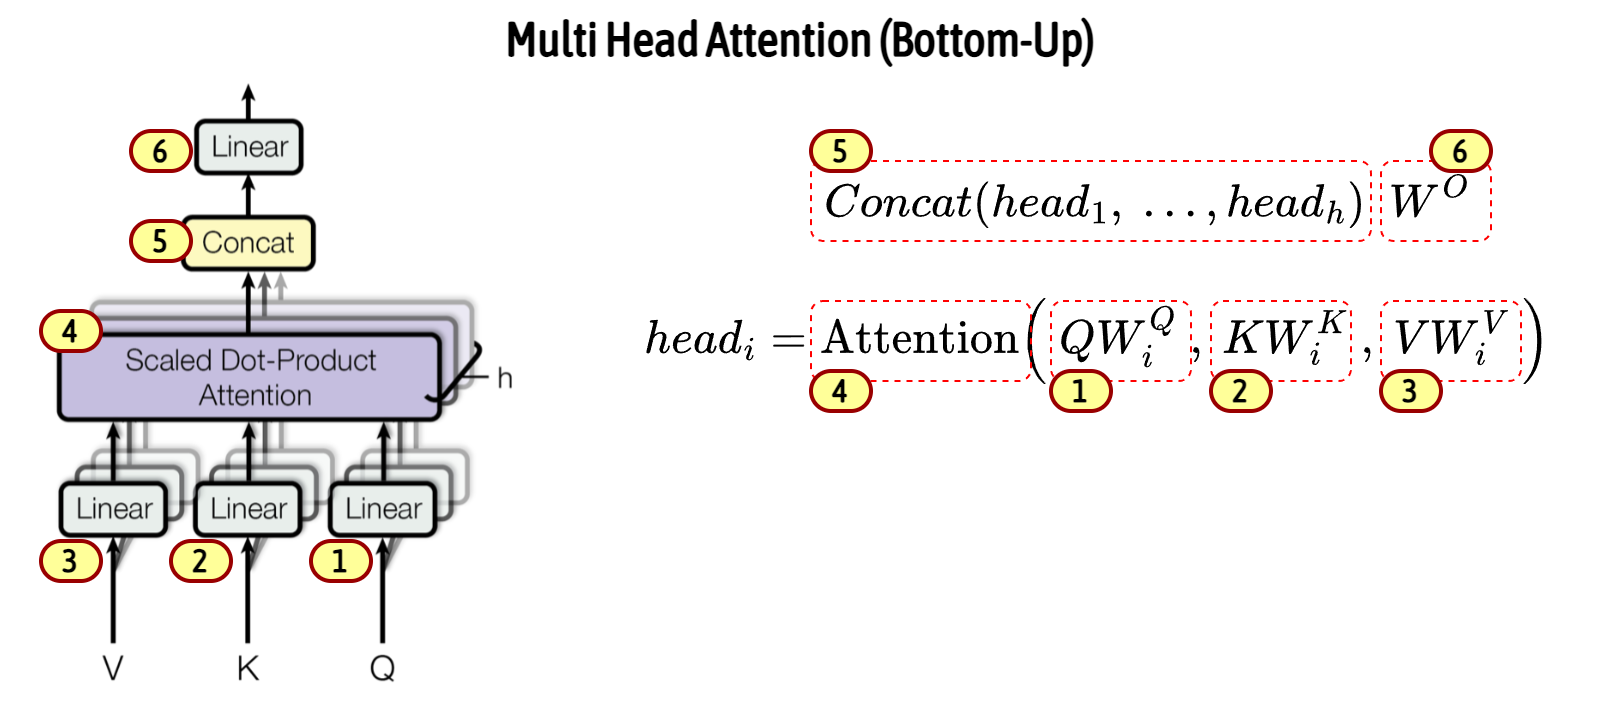

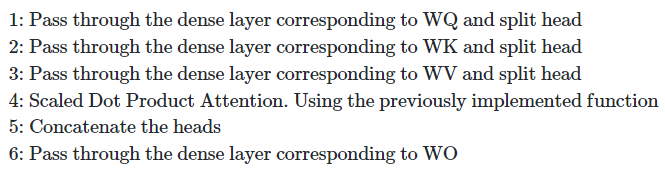

In [ ]:
def __init__(self, hid_dim, n_heads):

    pass

def split_heads(self, inputs, batch_size):
    """Split the last dimension into (n_heads, depth).
        Transpose the result such that the shape is (batch_size, n_heads, seq_len, depth)
        """
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

def call(self, value, key, query, mask, bidirectional = False):

    return outputs, attention_weights

# C04. Positionwise Feedforward Layer

In [ ]:
class PositionwiseFeedforwardLayer(tf.keras.layers.Layer):
    def __init__(self, hid_dim, pf_dim):
        pass

    def forward(self, attention):
        pass

# C05. Encoder Layer

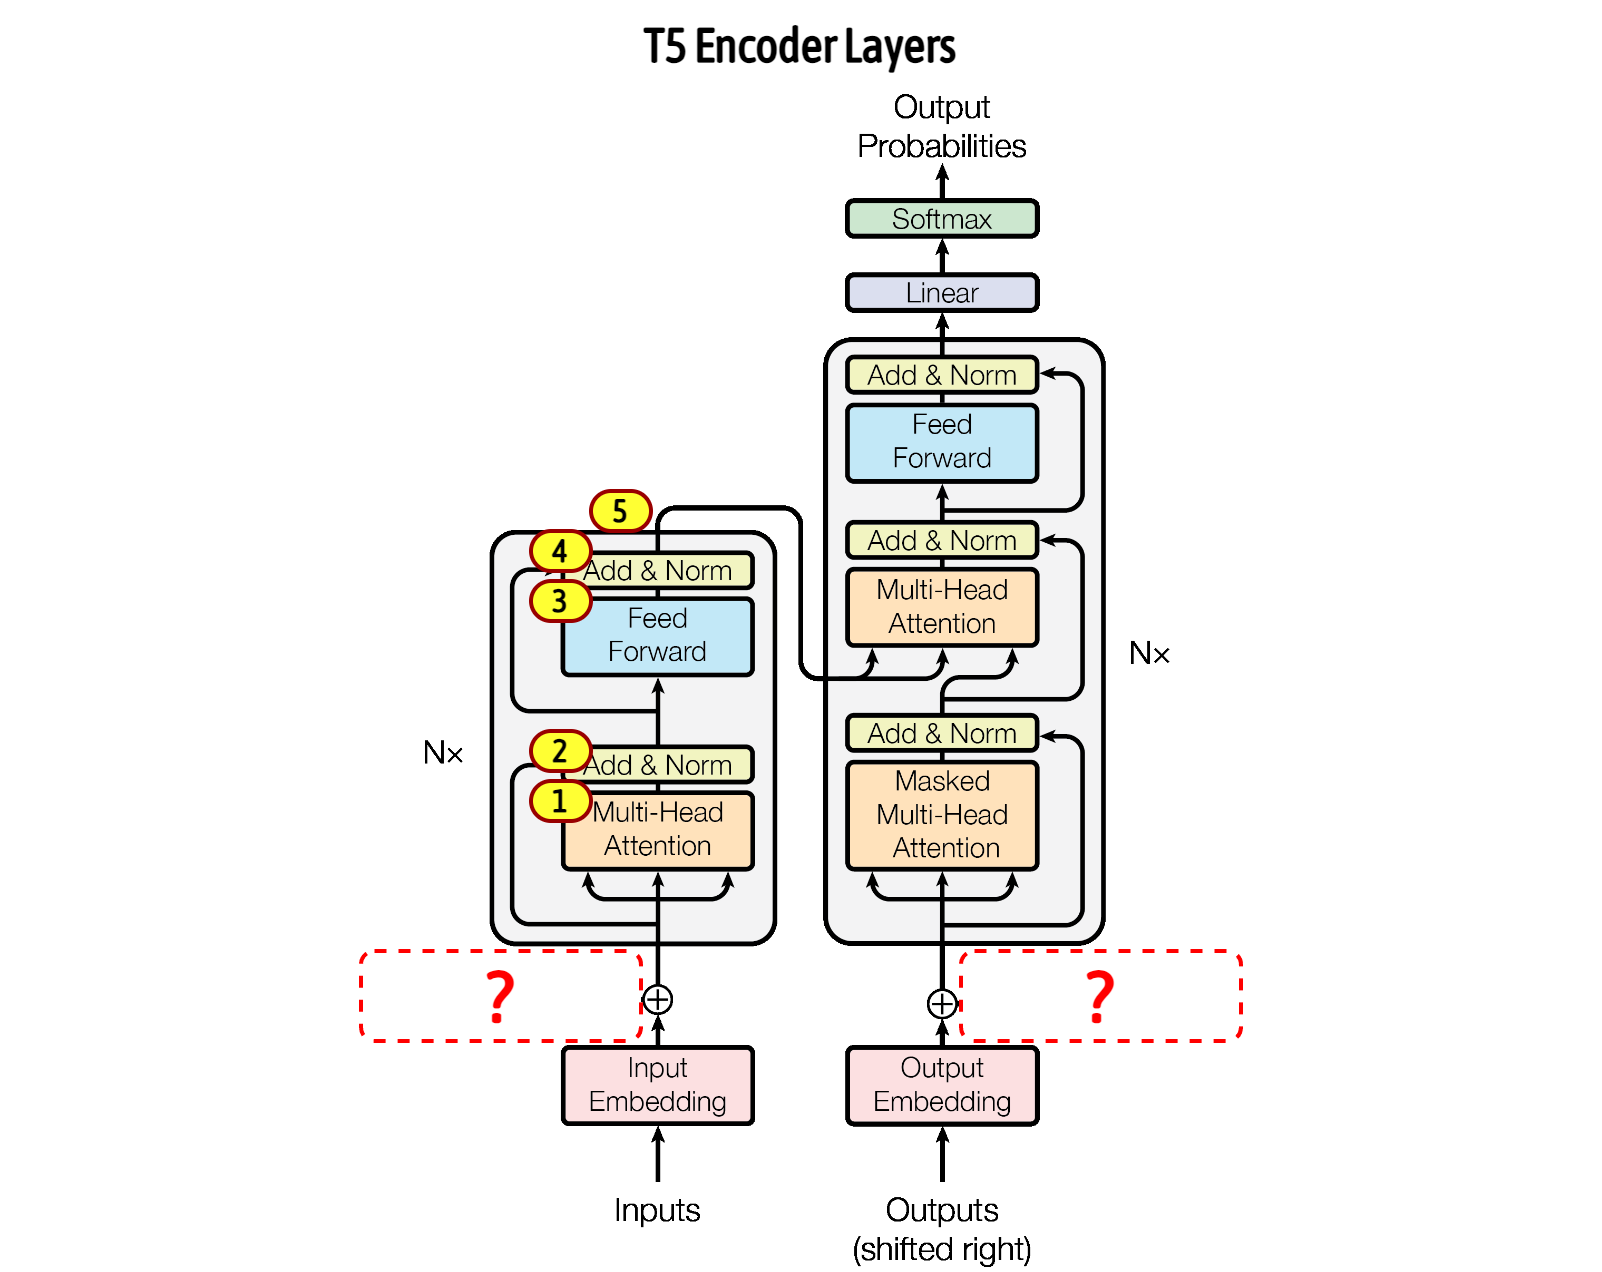

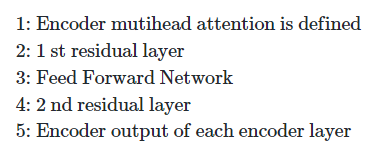

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, pf_dim, hid_dim, n_heads, dropout):
        super(EncoderLayer, self).__init__()

        pass

    def call(self, inputs, training, padding_mask):

        pass

        # 5. Encoder output of each encoder layer
        return ffn_outputs

# C06. Encoder

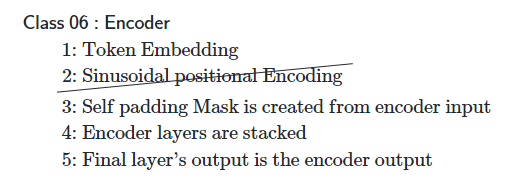

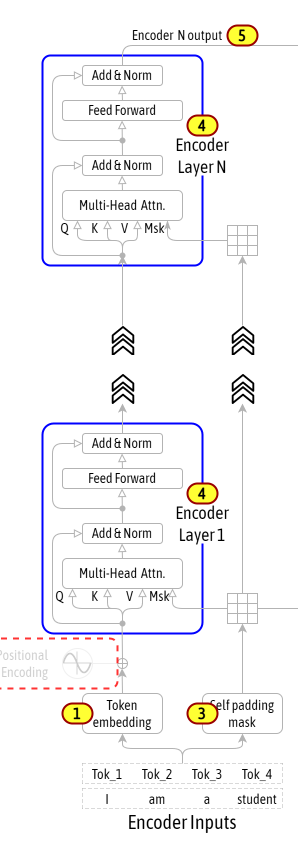

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, n_enc_vocab, n_layers, pf_dim, hid_dim, n_heads,
                 maximum_position_encoding, dropout):

    def call(self, x, training, padding_mask):

        # adding embedding and position encoding.
        # 1. Token Embedding

        # 3. Self padding Mask is created from encoder input

        # 5. Final layer's output is the encoder output


        return output  # (batch_size, input_seq_len, hid_dim)


In [ ]:
943 +

# C07. Decoder layer

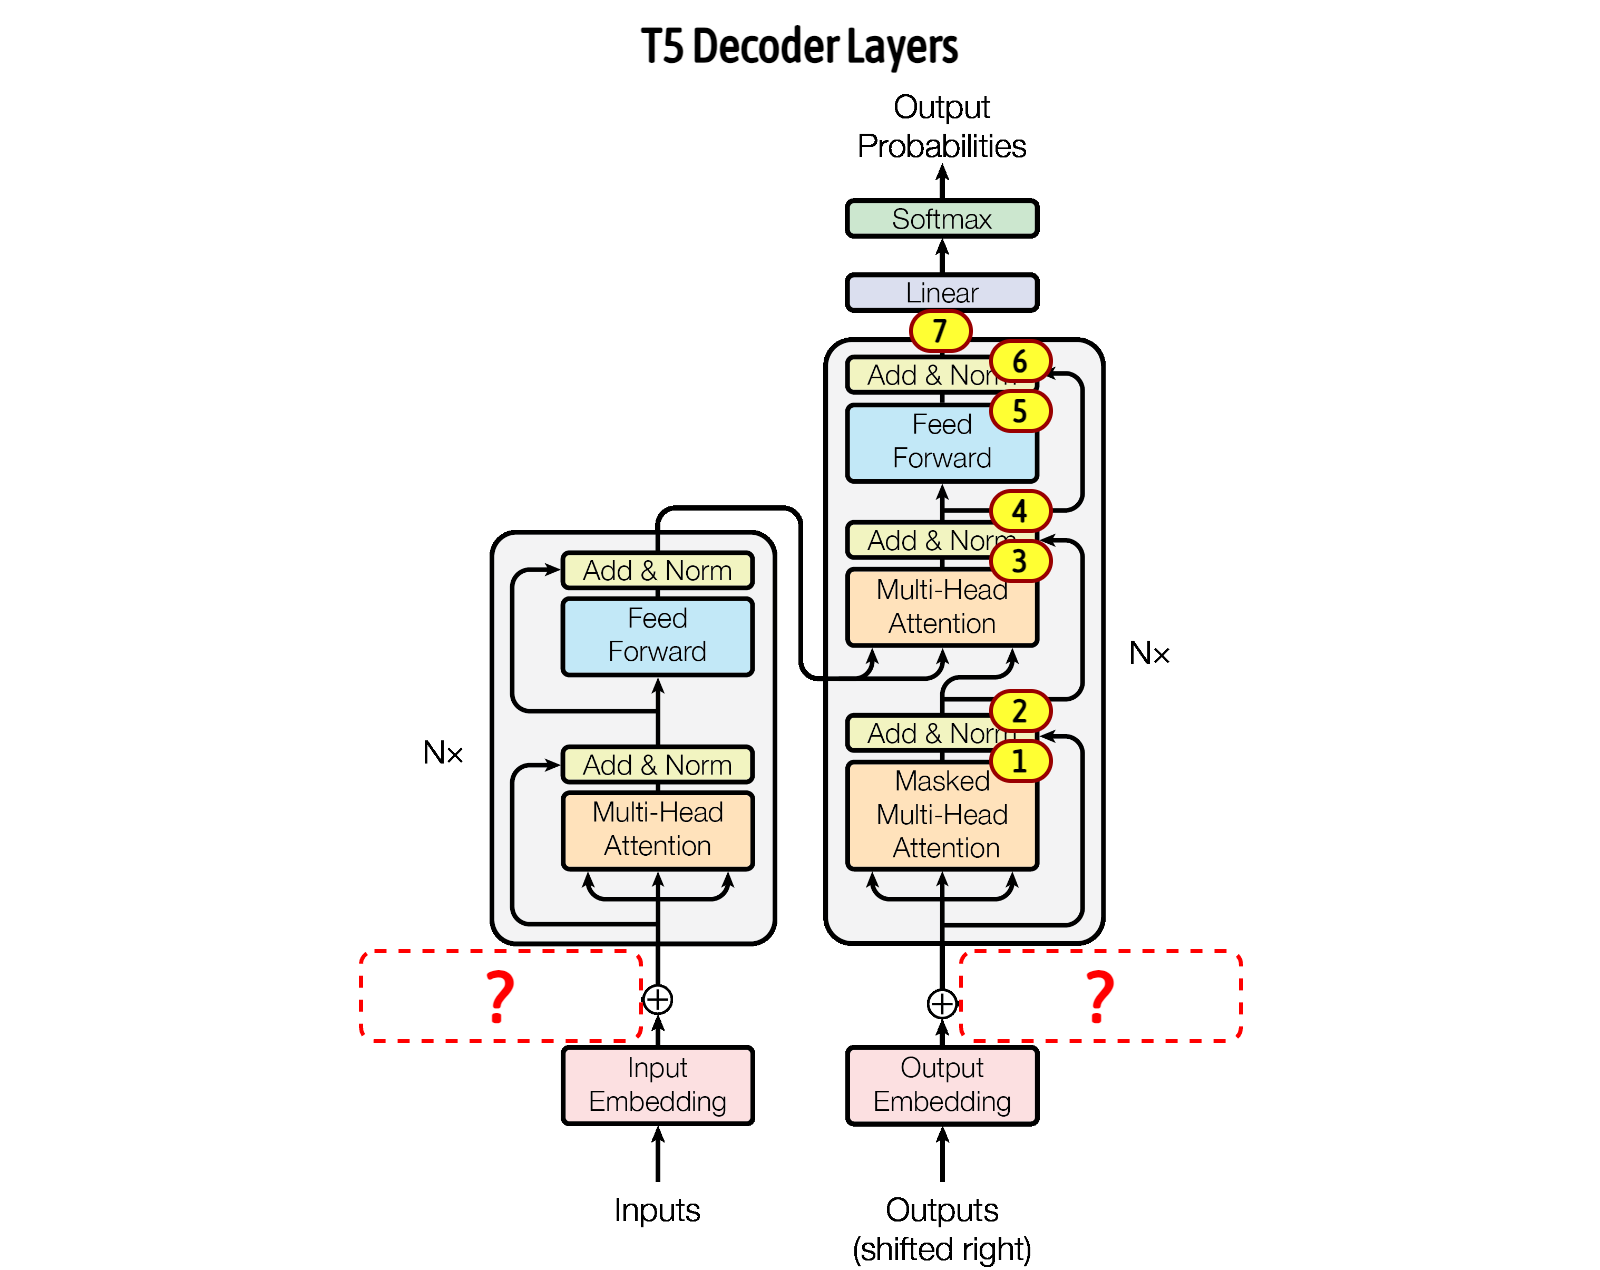

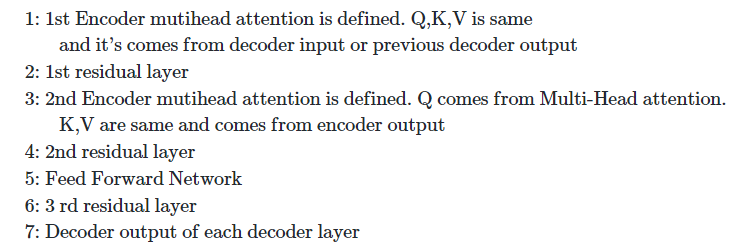

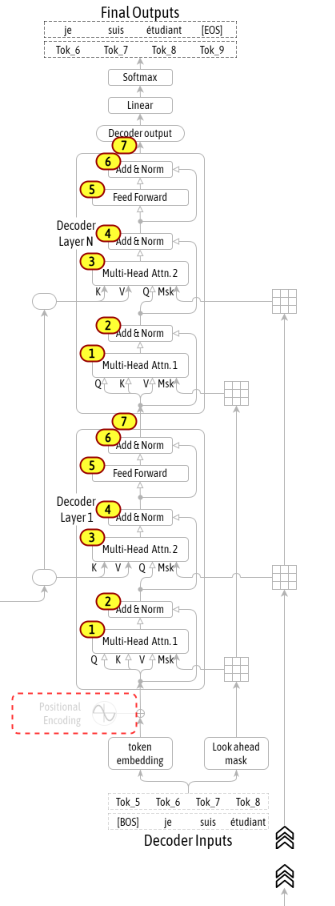

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, pf_dim, hid_dim, n_heads, dropout):
        super(DecoderLayer, self).__init__()

    def call(self, inputs, enc_output, training,
             look_ahead_mask, padding_mask):

        # 1. 1st Encoder mutihead attention is defined. Q,K,V is same and it's comes from decoder input or previous decoder output

        # 2. 1st residual layer

        # 3. 2nd Encoder mutihead attention is defined. Q comes from Multi-Head attention. K,V are same and comes from encoder output

        # 4. 2nd residual layer

        # 5. Feed Forward Network

        # 6. 3 rd residual layer

        # 7. Decoder output of each decoder layer

        return ffn_outputs, attn_weights_block1, attn_weights_block2


# C08. Decoder

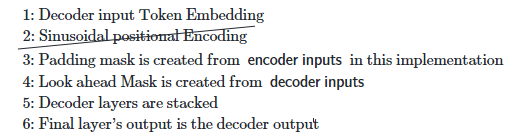

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, n_dec_vocab, n_layers, pf_dim, hid_dim, n_heads,
                 maximum_position_encoding, dropout):
        super(Decoder, self).__init__()

    def call(self, dec_input, enc_output, training,
             look_ahead_mask, padding_mask):

        # 1. Decoder input Token Embedding

        # 3. Padding mask is created from **encoder inputs** in this implementation

        # 4. Look ahead Mask is created from **decoder inputs**

        # 5. Decoder layers are stacked

        # 6. Final layer's output is the decoder output

        return output, attention_weights



# C09. Attention pad mask

In [ ]:
def create_padding_mask(seq):
    pass
    return seq[:, tf.newaxis, tf.newaxis, :]

# C10. Attention decoder mask (Look ahead mask)


In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

# C11. Create masks
1. Encoder padding mask
2. Decoder padidng mask
3. Look ahead mask

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

#C12. T5

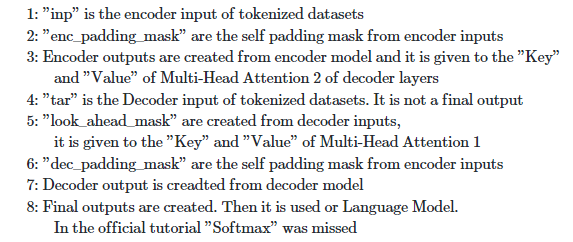

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, n_enc_vocab, n_dec_vocab,
                 n_layers, pf_dim, hid_dim, n_heads,
                 pe_input, pe_target, dropout):
        super(Transformer, self).__init__()


    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        # 1. "inp" is the encoder input of tokenized datasets
        # 2. "enc_padding_mask" are the self padding mask from encoder inputs

        # 3. Encoder outputs are created from encoder model and it is given to the "Key" and "Value" of Multi-Head Attention 2 of decoder layers
        # 4. "tar" is the Decoder input of tokenized datasets. It is not a final output
        # 5. "look_ahead_mask" are created from decoder inputs, it is given to the "Key" and "Value" of Multi-Head Attention 1
        # 6. "dec_padding_mask" are the self padding mask from encoder inputs

        # 7. Decoder output is creadted from decoder model

        # 8. Final outputs are created. Then it is used or Language Model. In the official tutorial "Softmax" was missed

        return final_output, attention_weights


---

# 3. MODEL ENGINEERING

# M01. Import Libraries for Data Engineering

In [4]:
cd /content/drive/MyDrive/projects/fra-eng-translation-with-t5-from-scratch

/content/drive/MyDrive/projects/fra-eng-translation-with-t5-from-scratch


In [5]:
# !python notebooks/A1_TF2_NMT_T5_fr_en_Keras_Tokenizer.py

2024-04-04 05:26:56.591069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 05:26:56.591122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 05:26:56.592972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 05:26:56.603390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 05:26:58.049511: W tensorflow/compiler/tf2

In [7]:
len("nous devrions toujours tous juste nous detendre un peu tot nous devrions toujours attendre juste nous detendre un peu tot nous devrions tous juste nous detendre juste nous detendre juste un peu juste un peu juste nous detendre juste nous detendre".split())

41